<a href="https://colab.research.google.com/github/michellemtf/NeuromatchProject/blob/main/activeSession_multiNeuron_cyl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Set up environment and import packages**

#### Install necessary packages

In [ ]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

Next we will import packages we need later in the notebook

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# **# Load the session and experiment summary tables**

In [3]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

Load summary tables

In [4]:
behavior_session_table = cache.get_behavior_session_table()
ophys_session_table    = cache.get_ophys_session_table()
ophys_experiment_table = cache.get_ophys_experiment_table()
#ophys_experiment_table.head()
#ophys_experiment_table['mouse_id']

In [5]:
ophys_session_table.session_type.unique()

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_3_images_A',
       'OPHYS_4_images_B', 'OPHYS_5_images_B_passive', 'OPHYS_6_images_B',
       'OPHYS_1_images_B', 'OPHYS_2_images_B_passive', 'OPHYS_3_images_B',
       'OPHYS_4_images_A', 'OPHYS_6_images_A', 'OPHYS_5_images_A_passive'],
      dtype=object)

In [ ]:
# Dictionary with session types
session_type = {'familiar_active':  ['OPHYS_1_images_A', 'OPHYS_3_images_A', 'OPHYS_4_images_A', 'OPHYS_6_images_A'],
                'novel_active':     ['OPHYS_1_images_B', 'OPHYS_3_images_B', 'OPHYS_4_images_B', 'OPHYS_6_images_B'],
                'familiar_passive': ['OPHYS_2_images_A_passive','OPHYS_5_images_A_passive'],
                'novel_passive':    ['OPHYS_2_images_B_passive','OPHYS_5_images_B_passive']} # note: I think "OPHYS_5_images_B_passive" is novel, but not sure

cre_line_type = ['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre']

print(f'*Ophys session types in the current dataset:*\n\n {ophys_session_table.session_type.unique()}',)             

In [7]:
#cyllll label took the active sessions
ind_active = (ophys_experiment_table.session_type.str.contains(session_type['familiar_active'][0]) |
              ophys_experiment_table.session_type.str.contains(session_type['familiar_active'][1]) |
              ophys_experiment_table.session_type.str.contains(session_type['familiar_active'][2]) |
              ophys_experiment_table.session_type.str.contains(session_type['familiar_active'][3]) |
              ophys_experiment_table.session_type.str.contains(session_type['novel_active'][0]) |
              ophys_experiment_table.session_type.str.contains(session_type['novel_active'][1]) |
              ophys_experiment_table.session_type.str.contains(session_type['novel_active'][2]) |
              ophys_experiment_table.session_type.str.contains(session_type['novel_active'][3])) 

ind_passive = (ophys_experiment_table.session_type.str.contains(session_type['familiar_passive'][0]) |
               ophys_experiment_table.session_type.str.contains(session_type['familiar_passive'][1]) |
               ophys_experiment_table.session_type.str.contains(session_type['novel_passive'][0]) |
               ophys_experiment_table.session_type.str.contains(session_type['novel_passive'][1])) 

In [ ]:
#print(ind_active.unique())
#print(np.size(ind_active))
#print(np.sum(ind_active == True))

In [ ]:
#print(ind_passive.unique())
#print(np.size(ind_passive))
#print(np.sum(ind_passive == True))


In [8]:
#add the 'behavior_condition' in the ophys_experiment_table head, to distinguish between 'active' and 'passive'
ind_active[ind_active==False] = 'passive'
ind_active[ind_active==True]  = 'active' 
ophys_experiment_table['behavior_condition'] = ind_active

In [9]:
print(np.size(ind_active))
print(ind_active.unique())
print(np.sum(ind_active == 'passive'))
print(np.sum(ind_active == 'active'))

1165
['active' 'passive']
339
826


In [10]:
# Familiar vs novel
fam = session_type['familiar_active'] + session_type['familiar_passive'] 

i_fam = pd.Series([False]*ophys_experiment_table.shape[0]) #shape, help find the dimensions of the array
for f in fam:
  i_fam = (i_fam | ophys_experiment_table.session_type.str.contains(f))
i_fam[i_fam==True]  = 'familiar'
i_fam[i_fam==False] = 'novel'  
ophys_experiment_table['experimental_condition'] = i_fam

In [11]:
#check the labels and condition numbers
print(np.size(i_fam,0)) # i don't understand this doubled the 1165
print(ophys_experiment_table.experimental_condition.unique())
print(np.sum(ophys_experiment_table.experimental_condition == 'familiar'))
print(np.sum(ophys_experiment_table.experimental_condition == 'novel'))

2330
['novel' 'familiar']
435
730


Find a container with familiar and novel sessions

In [12]:
# Containers-cyllllll -use the excitatory neuron here
i_fam = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "active" and experimental_condition == "familiar"')['ophys_container_id']
i_nov = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "active" and experimental_condition == "novel"')['ophys_container_id']

# Which containers are in both conditions
unic_fam = i_fam.unique()
i_both = []
for i,row in enumerate(unic_fam):
  if (row == i_nov.values).any():
    i_both.append(i)
    
# Choose the first container with fam & nov conditions
id_contain = unic_fam[i_both[0]]

In [13]:
print(np.size(i_both))
print(id_contain)

78
991913064


Select the experiments of a specific container

In [14]:
#cyllll
exper_famil = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "active" and experimental_condition == "familiar" and ophys_container_id == @id_contain')
exper_novel = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "active" and experimental_condition == "novel" and ophys_container_id == @id_contain')

In [ ]:
#exper_famil

In [ ]:
#exper_novel

## **Load one example session**

In [16]:
# Ophys experimental ID (choose the first experiment of familiar and novel conditions)
ophys_experiment_id_fam = exper_famil.index[0] 
ophys_experiment_id_nov = exper_novel.index[0]

# Download particular ophys experiments
fam_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_fam)
nov_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_nov)

Structure the data

In [17]:
nov_experiment_neural_data = ophys.build_tidy_cell_df(nov_experiment)
fam_experiment_neural_data = ophys.build_tidy_cell_df(fam_experiment)

## **Examine Cell IDs**

In [ ]:
#cyllllll
cell_ids_fam = fam_experiment_neural_data['cell_specimen_id'].unique()
print('there are {} unique cells for fam'.format(len(cell_ids_fam)))
print('cell ids are: {}'.format(cell_ids_fam))

cell_ids_nov = nov_experiment_neural_data['cell_specimen_id'].unique()
print('there are {} unique cells for nov'.format(len(cell_ids_nov)))
print('cell ids are: {}'.format(cell_ids_nov))

# Choose only one neuron ID
cell_id_fam = cell_ids_fam[0:2]
cell_id_nov = cell_ids_nov[0:2]

In [36]:
#fam_single_cell_timeseries = fam_experiment_neural_data.query('cell_specimen_id == @cell_id_fam')
#nov_single_cell_timeseries = nov_experiment_neural_data.query('cell_specimen_id == @cell_id_nov')

In [26]:
#cyllll
fam_stimulus_table = fam_experiment.stimulus_presentations
nov_stimulus_table = nov_experiment.stimulus_presentations

In [ ]:
#for cell_idssss in cell_id_nov:
ETR_NOV = np.zeros([4264, 2]) #pick 2 neuron first
i = 0
for temp_cell_id in cell_id_nov:
  etr_nov = mindscope_utilities.event_triggered_response(
  data = nov_experiment_neural_data.query('cell_specimen_id == @temp_cell_id'),
  t = 'timestamps',
  y = 'dff',
  event_times = nov_stimulus_table.query('is_change == False and omitted == False')['start_time'], #no change images
  t_before=0,
  t_after=0.5,
  output_sampling_rate = 1,
  )
  #print(np.size(etr_nov.dff, 0))
  ETR_NOV[:,i] = etr_nov.dff
  i = i+1

In [48]:
#for cell_idssss in cell_id_nov:
ETR_FAM = np.zeros([4278, 2]) #pick 2 neuron first
i = 0
for temp_cell_id in cell_id_fam:
  etr_fam = mindscope_utilities.event_triggered_response(
  data = fam_experiment_neural_data.query('cell_specimen_id == @temp_cell_id'),
  t = 'timestamps',
  y = 'dff',
  event_times = fam_stimulus_table.query('is_change == False and omitted == False')['start_time'], #no change images
  t_before=0,
  t_after=0.5,
  output_sampling_rate = 1,
  )
  print(np.size(etr_fam.dff, 0))
  ETR_FAM[:,i] = etr_fam.dff
  i = i+1

4278
4278


In [ ]:
event_times = nov_stimulus_table.query('is_change == False  and omitted == False')['start_time']
print(np.size(event_times))

(array([ 0.12138832,  0.93375629,  2.99735769,  7.17124831, 10.26198163,
         9.75775323,  5.47181186,  2.37174098,  0.64429184,  0.21476395]),
 array([-0.13053059, -0.10549686, -0.08046312, -0.05542938, -0.03039565,
        -0.00536191,  0.01967183,  0.04470556,  0.0697393 ,  0.09477304,
         0.11980677]),
 <a list of 10 Patch objects>)

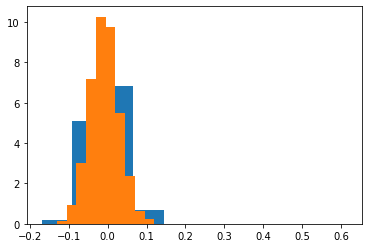

In [50]:
plt.hist(etr_nov.dff, density = True)
plt.hist(etr_fam.dff, density = True)